# Análisis del problema

Utilizando redes convolucionales para clasificar si hay o no tatuaje en la imagen utilizando el siguiente dataset

# Autores
   * Luz Clara Mora Salazar
   * Julio César Castro Ortiz


# Librerías

In [2]:
import os
import random
import scipy.io.wavfile as wav

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

# Nota
Debe descargar el zip y agregarlo al root del proyecto
https://github.com/nahum0804/tattoDetectorDataset/archive/refs/heads/main.zip

In [8]:
import zipfile

# Ruta al archivo zip
zip_path = "tattoDetectorDataset-main.zip"
# Ruta al directorio donde quieres descomprimir el archivo
extract_path = "tattoDetectorDataset-main"
# Descomprimir el archivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Archivo descomprimido en: {extract_path}")

Archivo descomprimido en: tattoDetectorDataset-main


# Procesamiento de Datos

In [9]:
def preprocess_and_save_image(src, dst, size=(100, 100)):
    img = Image.open(src)
    img = img.resize(size)
    # Convertir la imagen a modo RGB
    img = img.convert('RGB')
    img.save(dst)


def split_dataset(input_folder, output_folder, train_ratio=0.7, test_ratio=0.2, val_ratio=0.1, seed=None):

    if seed is not None:
        random.seed(seed)

    # Crear carpetas de salida
    train_dir = os.path.join(output_folder, 'train')
    test_dir = os.path.join(output_folder, 'test')
    val_dir = os.path.join(output_folder, 'val')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Iterar sobre subcarpetas
    for class_folder in os.listdir(input_folder):
        class_path = os.path.join(input_folder, class_folder)
        if os.path.isdir(class_path):
            class_files = os.listdir(class_path)
            random.shuffle(class_files)

            # Calcular el número de ejemplos para cada división.
            num_samples = len(class_files)
            num_train = int(train_ratio * num_samples)
            num_test = int(test_ratio * num_samples)
            num_val = num_samples - num_train - num_test

            # Asignar archivos a cada división
            train_files = class_files[:num_train]
            test_files = class_files[num_train:num_train + num_test]
            val_files = class_files[-num_val:]

            for files, folder in zip([train_files, test_files, val_files], [train_dir, test_dir, val_dir]):
                for filename in files:
                    src = os.path.join(class_path, filename)
                    dst = os.path.join(folder, class_folder, filename)
                    os.makedirs(os.path.dirname(dst), exist_ok=True)
                    preprocess_and_save_image(src, dst)


# Ejemplo:
input_folder = "./tattoDetectorDataset-main/tattoDetectorDataset-main/"  # Ruta a la carpeta que contiene subcarpetas para cada clase
output_folder = "./Tatto_procesadas"  # Ruta a la carpeta de salida donde se guardarán los conjuntos de train test  val
split_dataset(input_folder, output_folder)

# Entendimiento de los datos

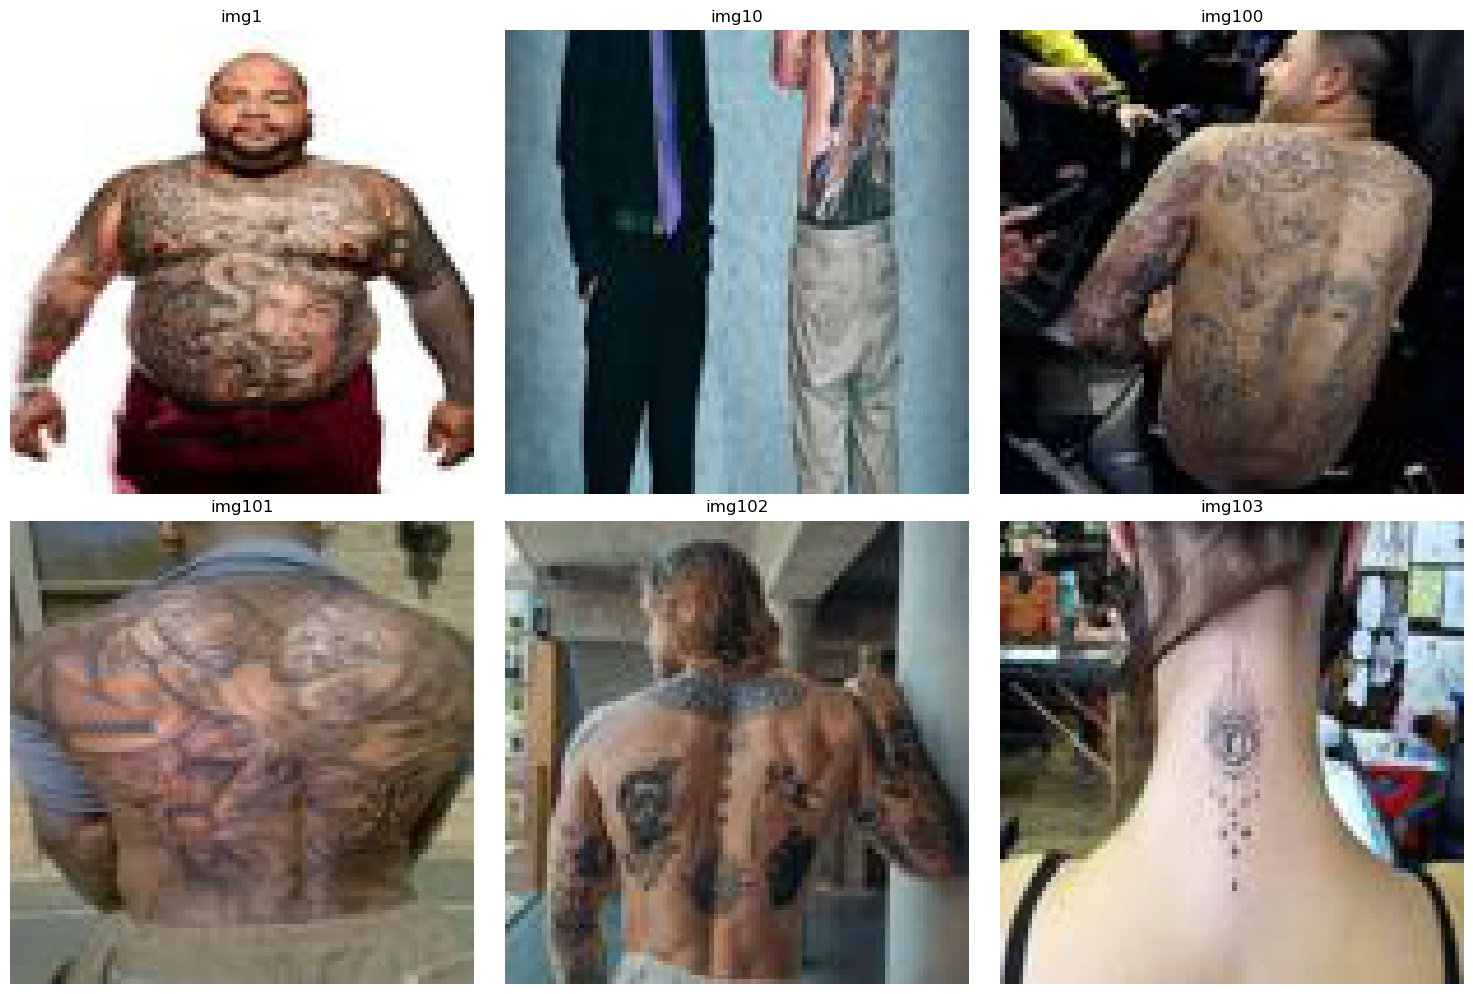

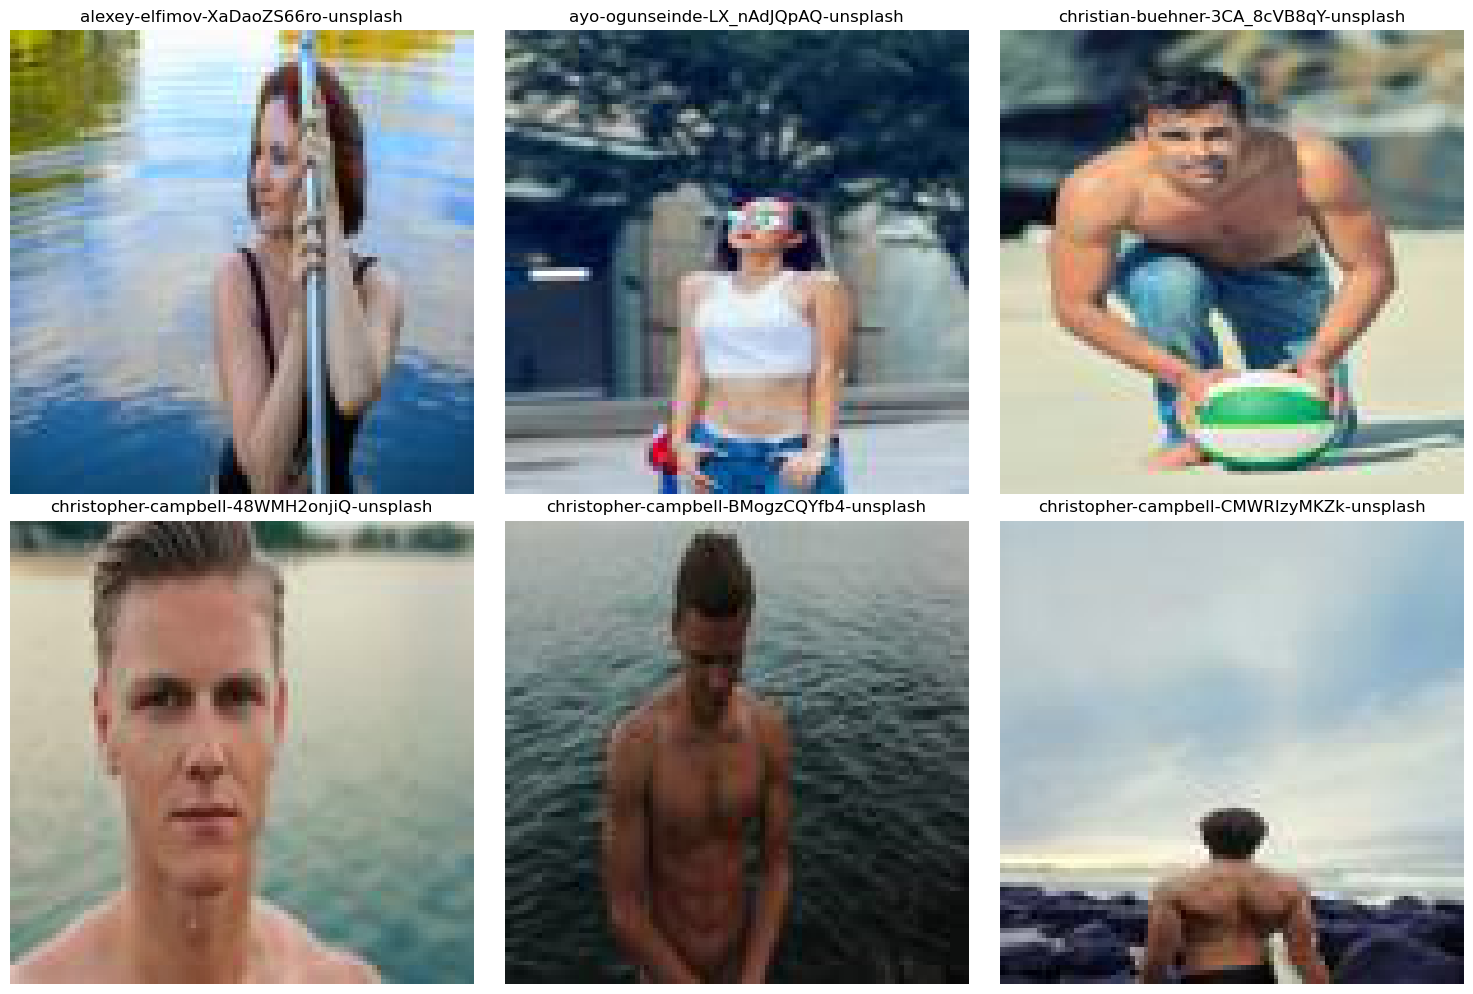

In [3]:
def display_images_with_labels(path, num_images=6):
    # Get a list of all image file names in the directory
    image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    
    # Display the images with their labels
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for i in range(min(num_images, len(image_files))):
        # Get the image file name and its label
        image_file = image_files[i]
        label = image_file.split('.')[0]

        # Load and display the image
        img_path = os.path.join(path, image_file)
        img = mpimg.imread(img_path)
        ax = axs[i // 3, i % 3]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)

    plt.tight_layout()
    plt.show()

# Example usage:
path = "Tatto_procesadas/train/withTatto"
display_images_with_labels(path)

path = "Tatto_procesadas/train/withoutTatto"
display_images_with_labels(path)

# Procesamiento de los datos

In [17]:
# Define data augmentation and normalization parameters for training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Rotate images randomly up to 40 degrees
    width_shift_range=0.2,  # Shift images horizontally up to 20% of the width
    height_shift_range=0.2, # Shift images vertically up to 20% of the height
    shear_range=0.2,        # Shear intensity
    zoom_range=0.2,         # Zoom in randomly up to 20%
    horizontal_flip=True,   # Flip images horizontally
    fill_mode='nearest'     # Fill in newly created pixels after rotation or shifting
)

# Create a data generator for training data with one-hot encoded labels
train_generator = train_datagen.flow_from_directory(
    'Tatto_procesadas/train',
    target_size=(100, 100),
    batch_size=10,
    class_mode='binary',  # Change class_mode to 'categorical'
    shuffle=True)  # Shuffle the data

# Define data augmentation and normalization parameters for validation data
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create a data generator for validation data with one-hot encoded labels
val_generator = val_datagen.flow_from_directory(
    'Tatto_procesadas/val',
    target_size=(100, 100),
    batch_size=10,
    class_mode='binary',  # Change class_mode to 'categorical'
    shuffle=False)  # No need to shuffle validation data

Found 284 images belonging to 2 classes.
Found 41 images belonging to 2 classes.


# Modelo de Deep Learning

In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = VGG16(input_shape=(100, 100, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Congelar la base pre-entrenada

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

58889256/58889256 [==============================] - 5s 0us/step


In [27]:
# Compilar el modelo
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Definir el callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Definir el callback ModelCheckpoint
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
29/29 [==============================] - 5s 92ms/step - loss: 0.7498 - accuracy: 0.4754 - val_loss: 0.6624 - val_accuracy: 0.6098
Epoch 2/100
29/29 [==============================] - 1s 45ms/step - loss: 0.6909 - accuracy: 0.5880 - val_loss: 0.6295 - val_accuracy: 0.6341
Epoch 3/100
29/29 [==============================] - 1s 45ms/step - loss: 0.6683 - accuracy: 0.5880 - val_loss: 0.6055 - val_accuracy: 0.7561
Epoch 4/100
29/29 [==============================] - 1s 44ms/step - loss: 0.6650 - accuracy: 0.6056 - val_loss: 0.5879 - val_accuracy: 0.7561
Epoch 5/100
29/29 [==============================] - 1s 45ms/step - loss: 0.6223 - accuracy: 0.6655 - val_loss: 0.5722 - val_accuracy: 0.7317
Epoch 6/100
29/29 [==============================] - 1s 46ms/step - loss: 0.6258 - accuracy: 0.6549 - val_loss: 0.5542 - val_accuracy: 0.7561
Epoch 7/100
29/29 [==============================] - 1s 46ms/step - loss: 0.6050 - accuracy: 0.6655 - val_loss: 0.5399 - val_accuracy: 0.7561
Epoch 

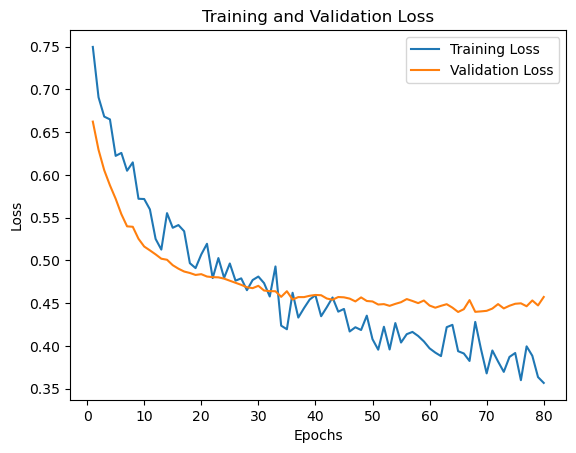

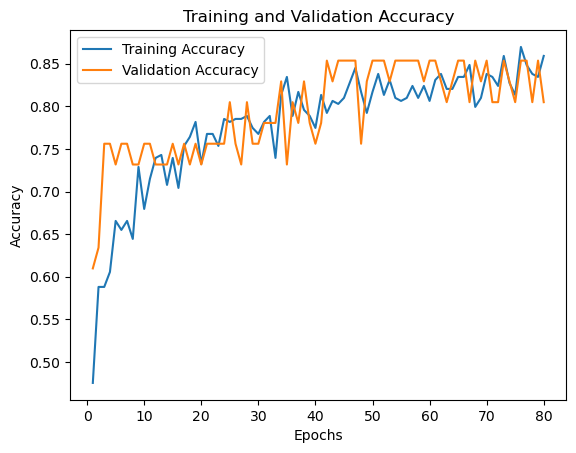

In [28]:
# Get the training metrics
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Get the validation metrics
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
# Save the trained model
model.save("tatto.h5")

# Predicción y Evaluación
 

In [22]:
# Define data augmentation and normalization parameters for validation data
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create a data generator for validation data with one-hot encoded labels
test_generator = test_datagen.flow_from_directory(
    'Tatto_procesadas/test',
    target_size=(100, 100),
    batch_size=5,
    class_mode='binary',  # Change class_mode to 'categorical'
    shuffle=False)  # No need to shuffle validation data

Found 81 images belonging to 2 classes.


17/17 [==============================] - 1s 14ms/step - loss: 0.3957 - accuracy: 0.8272
Test Loss: 0.3957393765449524
Test Accuracy: 0.8271604776382446
17/17 [==============================] - 0s 12ms/step


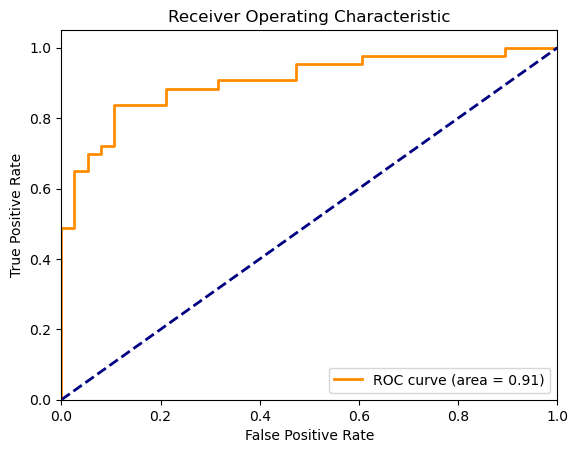

In [30]:
model.load_weights('best_model.h5')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Get the true labels and predicted probabilities for the test data
true_labels = test_generator.classes
predicted_probabilities = model.predict(test_generator)

# Plot the ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Conclusión

En resumen, el modelo alcanzó una alta precisión (accuracy) tanto en los datos de entrenamiento como en los de validación, con valores que oscilaron alrededor del 85% en promedio. Durante las últimas épocas del entrenamiento la precisión en los datos de validación se mantuvo alta, alcanzando hasta un 80%, lo que indica que el modelo generalizó bien a datos no vistos. 

Basándonos en los resultados obtenidos, el modelo alcanzó una precisión (accuracy) del 82% en los datos de prueba, con una pérdida (loss) de aproximadamente 39%. Estos resultados indican que el modelo generaliza bien a datos no vistos, ya que mantiene una alta precisión en los datos de prueba. Es importante destacar que la pérdida y la precisión obtenidas en los datos de prueba son consistentes con las métricas observadas durante el entrenamiento y validación del modelo, lo que sugiere que el modelo no ha sufrido de sobreajuste y que ha aprendido patrones generalizables de los datos de entrenamiento.